
# XGBoost classification 

### We'll be trying to predict a classification- survival or deceased.
## Import Libraries
### Let's import some libraries to get started!

In [8]:
#%ls

In [145]:
%cd titanic

[Errno 2] No such file or directory: 'titanic'
/Users/garbamoussa/Desktop/Python_ML/titanic


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import seaborn as sns
import sys
%matplotlib inline

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold
from sklearn.feature_selection import SelectPercentile
from hyperopt import hp,fmin,Trials, tpe, STATUS_FAIL, STATUS_OK, space_eval, anneal
from hyperopt.pyll import scope
from hyperopt.pyll import stochastic
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import time
random_state = 42
kf = KFold(n_splits=2,random_state=random_state)
n_iter= 50


# 1. Data Loading  
### Dimension of Dataset 
### Peek at the data itsef 
### Statistical summary of all attributes 
### Breakdown of the data by the class variable 
## Data importation and preparation 


In [10]:
## Load Dataset 
train = pd.read_csv('/Users/garbamoussa/Desktop/Python_ML/titanic/train.csv')
test = pd.read_csv('/Users/garbamoussa/Desktop/Python_ML/titanic/test.csv')

## Dimension of Dataset

In [11]:
train.shape

(891, 12)

In [12]:
#arrange data into list for labels and list of lists for attributes
xList = []
labels = []
for line in train:
    #split on comma
    row = line.strip().split(",")
    xList.append(row)
sys.stdout.write("Number of Rows of Data = " + str(len(xList)) + '\n')
sys.stdout.write("Number of Columns of Data = " + str(len(xList[1])))



Number of Rows of Data = 12
Number of Columns of Data = 1

In [13]:
print(f'{train.shape[0]} samples and {train.shape[1]} features in the training dataset.')

891 samples and 12 features in the training dataset.


Dataset comprises of 891 observations and 12 characteristics

Out of which one is dependent variable and rest 11 are independent variables

## Peek at the Data 

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


It is also a good practice to know the columns and their corresponding data types,along with finding whether they contain null values or not

Data has  float, nteger and object values

There are some variables column have null/missing values.

In [17]:

train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Statistical Summary

In [18]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Here as you can notice mean value is less than median value of each column which is represented by 50%(50th percentile) in index column.

There is notably a large difference between 75th %tile and max values of predictors “residual sugar”,”free sulfur dioxide”,”total sulfur dioxide”.

Thus observations 1 and 2 suggests that there are extreme values-Outliers in our data set.

In [19]:
#train["PassengerId"].value_counts()

In [20]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [21]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [22]:
#train["Age"].value_counts()

In [23]:
train["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [24]:
train["Parch"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [25]:
#train["Fare"].value_counts()

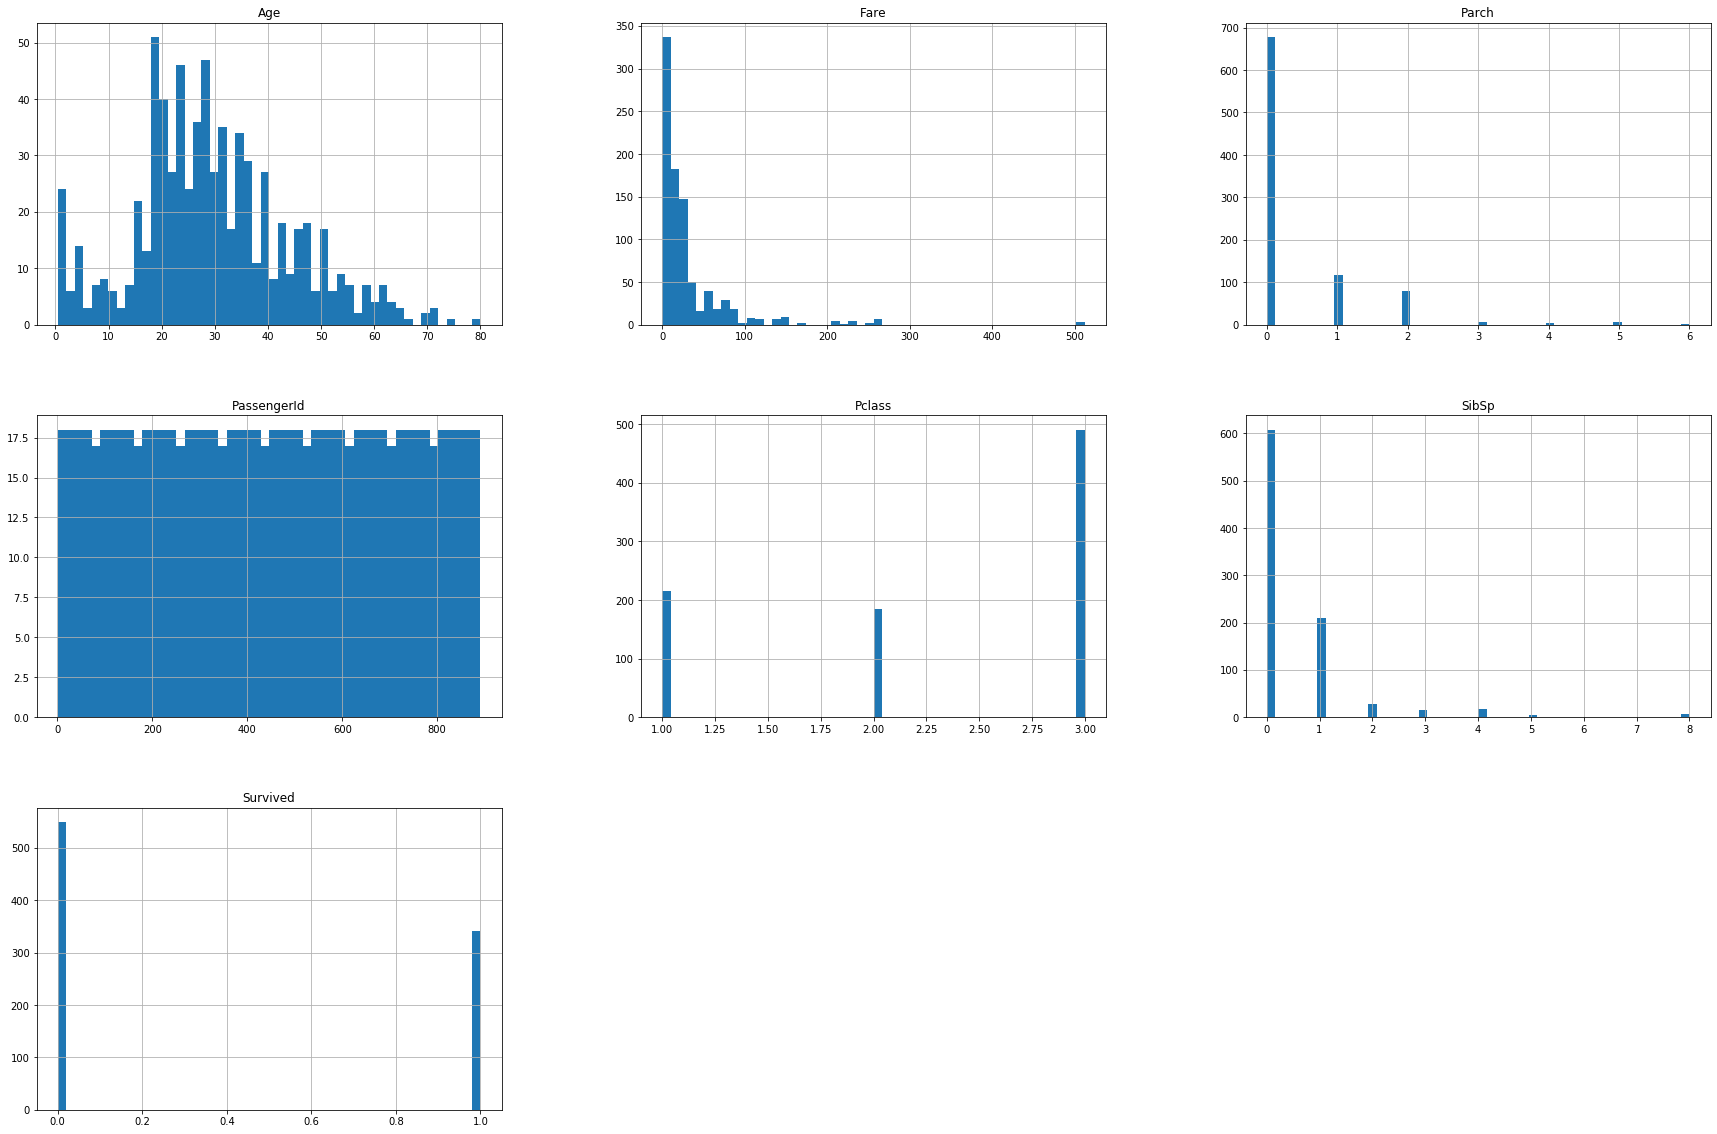

In [26]:
train.hist(bins=50, figsize=(30,20));

# Exploratory Data Analysis

## Missing Data
## Outliers detection in Data 
## Class Distribution 


## Data Visualization 
### Univariate Plots 
### Multivariate Plots 

# Missing Data 

In [27]:

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [28]:
def resumetable(df):
    from scipy import stats
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [29]:
missing_data(train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Total,0,0,0,0,0,177,0,0,0,0,687,2
Percent,0,0,0,0,0,19.8653,0,0,0,0,77.1044,0.224467
Types,int64,int64,int64,object,object,float64,int64,int64,object,float64,object,object


In [30]:
resumetable(train)

Dataset Shape: (891, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,PassengerId,int64,0,891,1,2,3,9.80
1,Survived,int64,0,2,0,1,1,0.96
2,Pclass,int64,0,3,3,1,3,1.44
3,Name,object,0,891,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina",9.80
4,Sex,object,0,2,male,female,female,0.94
5,Age,float64,177,88,22,38,26,5.84
6,SibSp,int64,0,7,1,1,0,1.34
7,Parch,int64,0,7,0,0,0,1.13
8,Ticket,object,0,681,A/5 21171,PC 17599,STON/O2. 3101282,9.23
9,Fare,float64,0,248,7.25,71.2833,7.925,7.04


Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"



Text(0, 0.5, 'Occurrence')

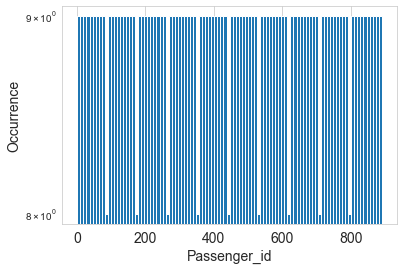

In [31]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['PassengerId'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Passenger_id', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)


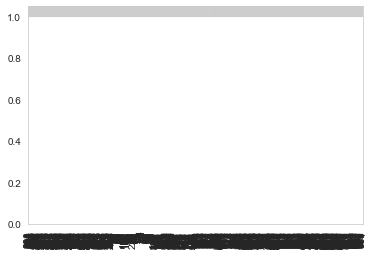

In [32]:
train['PassengerId'].value_counts().plot(kind='bar')

Text(0, 0.5, 'Occurrence')

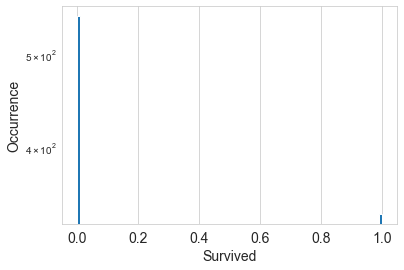

In [33]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Survived'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Survived', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)



Text(0, 0.5, 'Occurrence')

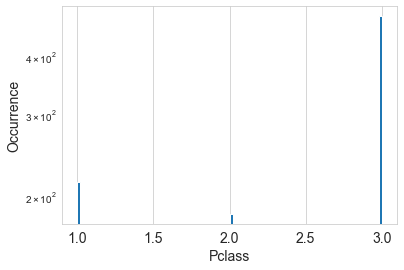

In [34]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Pclass'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Pclass', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)




Text(0, 0.5, 'Occurrence')

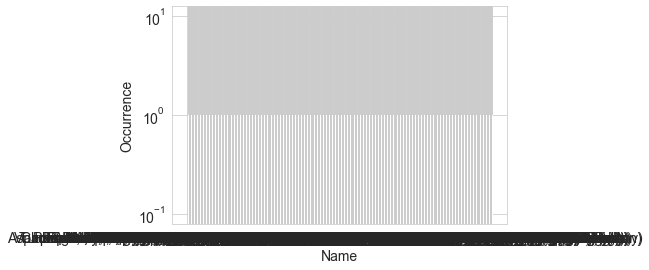

In [35]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Name'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Name', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

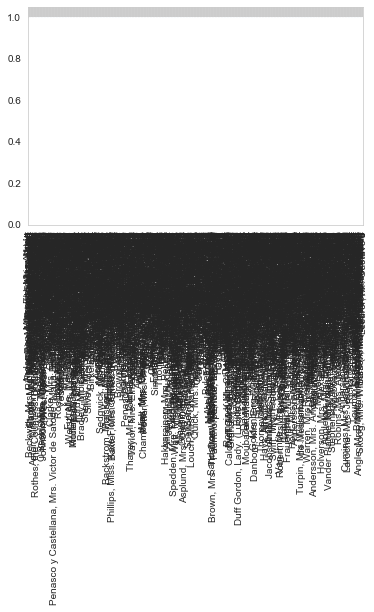

In [36]:
train['Name'].value_counts().plot(kind='bar')

Text(0, 0.5, 'Occurrence')

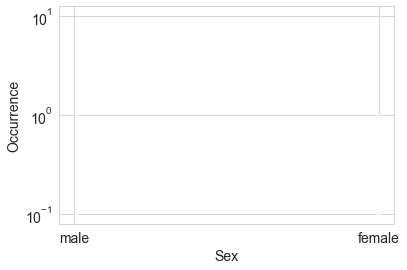

In [37]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Sex'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Sex', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

Text(0, 0.5, 'Occurrence')

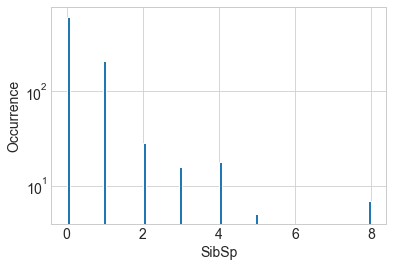

In [155]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['SibSp'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('SibSp', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

Text(0, 0.5, 'Occurrence')

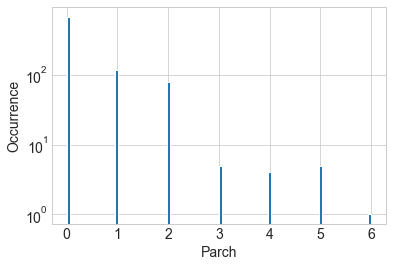

In [156]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Parch'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Parch', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

Text(0, 0.5, 'Occurrence')

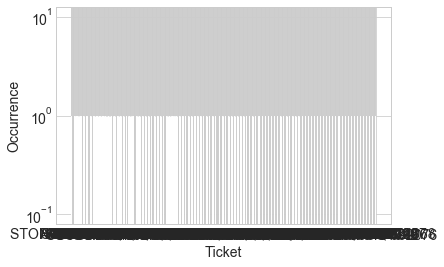

In [157]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Ticket'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Ticket', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

In [ ]:
train['Ticket'].value_counts().plot(kind='bar')

Text(0, 0.5, 'Occurrence')

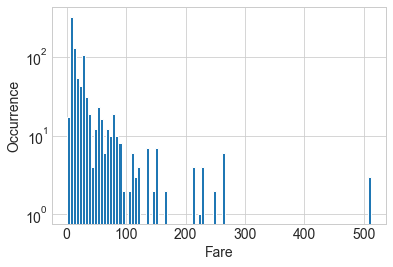

In [158]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Fare'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Fare', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

Text(0, 0.5, 'Occurrence')

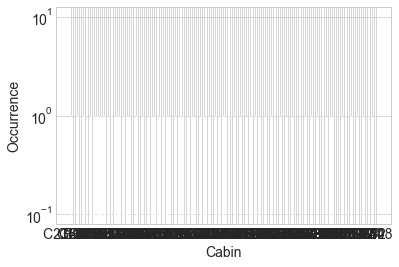

In [159]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Cabin'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Cabin', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

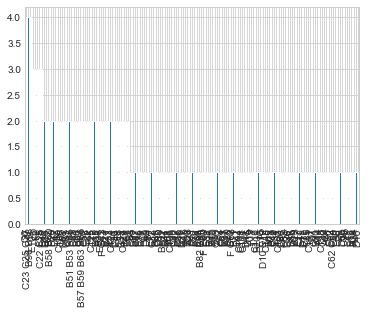

In [163]:
train['Cabin'].value_counts().plot(kind='bar')

Text(0, 0.5, 'Occurrence')

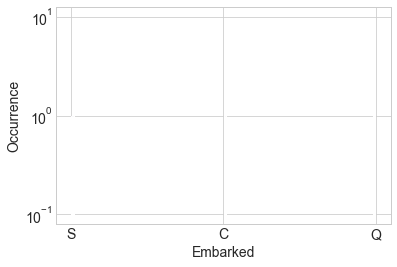

In [160]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
train['Embarked'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Embarked', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

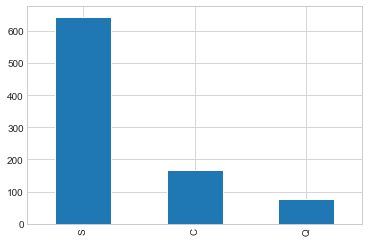

In [164]:
train['Embarked'].value_counts().plot(kind='bar')

# Outliers detection in Data

((array([-3.16416595e+00, -2.89636677e+00, -2.74675222e+00, -2.64114608e+00,
         -2.55870259e+00, -2.49067391e+00, -2.43252738e+00, -2.38160005e+00,
         -2.33618969e+00, -2.29513992e+00, -2.25762808e+00, -2.22304736e+00,
         -2.19093694e+00, -2.16093830e+00, -2.13276686e+00, -2.10619283e+00,
         -2.08102787e+00, -2.05711563e+00, -2.03432484e+00, -2.01254418e+00,
         -1.99167841e+00, -1.97164537e+00, -1.95237369e+00, -1.93380097e+00,
         -1.91587229e+00, -1.89853909e+00, -1.88175821e+00, -1.86549107e+00,
         -1.84970311e+00, -1.83436318e+00, -1.81944313e+00, -1.80491744e+00,
         -1.79076290e+00, -1.77695830e+00, -1.76348425e+00, -1.75032296e+00,
         -1.73745806e+00, -1.72487445e+00, -1.71255819e+00, -1.70049636e+00,
         -1.68867698e+00, -1.67708890e+00, -1.66572174e+00, -1.65456583e+00,
         -1.64361212e+00, -1.63285214e+00, -1.62227795e+00, -1.61188210e+00,
         -1.60165759e+00, -1.59159783e+00, -1.58169661e+00, -1.57194806e+00,

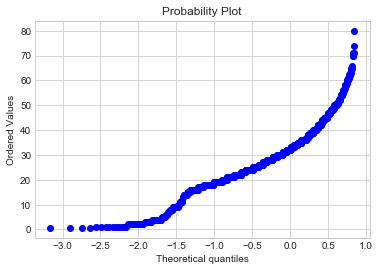

In [116]:
import pylab
import scipy.stats as stats
stats.probplot(train.Age, dist="norm", plot=pylab)

In [171]:
#stats.probplot(train.SibSp, dist="norm", plot=pylab)

In [170]:
#stats.probplot(train.Parch, dist="norm", plot=pylab)

In [169]:
#stats.probplot(train.Fare, dist="norm", plot=pylab)

In [167]:
#stats.probplot(train.Survived, dist="norm", plot=pylab)

In [168]:
#stats.probplot(train.Pclass, dist="norm", plot=pylab)

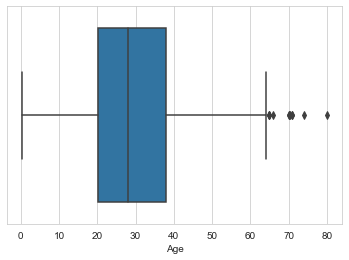

In [38]:
import seaborn as sns
sns.boxplot(x=train['Age'])

Above plot shows seven  points between 65 to 80, these are outliers as there 
are not included in the box of other observation i.e no where near the quartiles. 

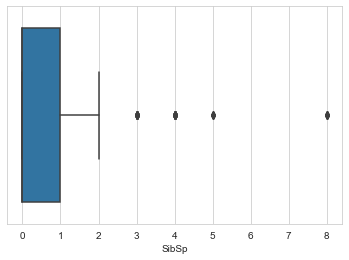

In [39]:
sns.boxplot(x=train['SibSp'])

Above plot shows seven  points between 2 to 8, these are outliers as there 
are not included in the box of other observation i.e no where near the quartiles. 

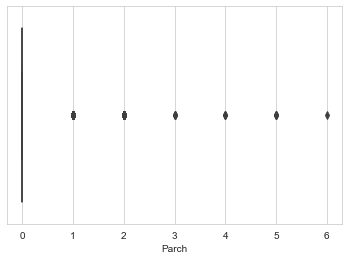

In [40]:
sns.boxplot(x=train['Parch'])

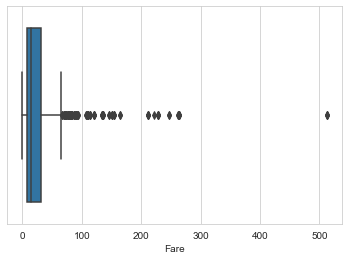

In [41]:
sns.boxplot(x=train['Fare'])

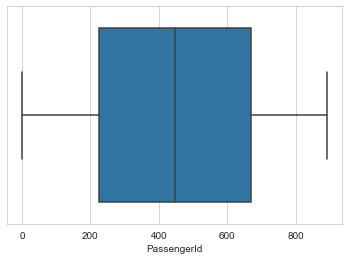

In [42]:
sns.boxplot(x=train['PassengerId'])

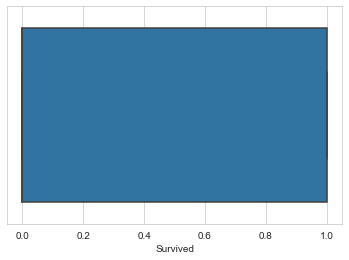

In [43]:
sns.boxplot(x=train['Survived'])

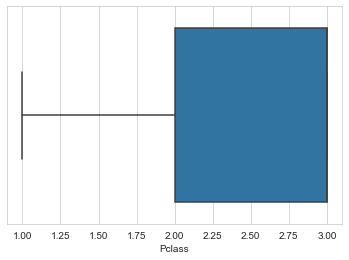

In [44]:
sns.boxplot(x=train['Pclass'])

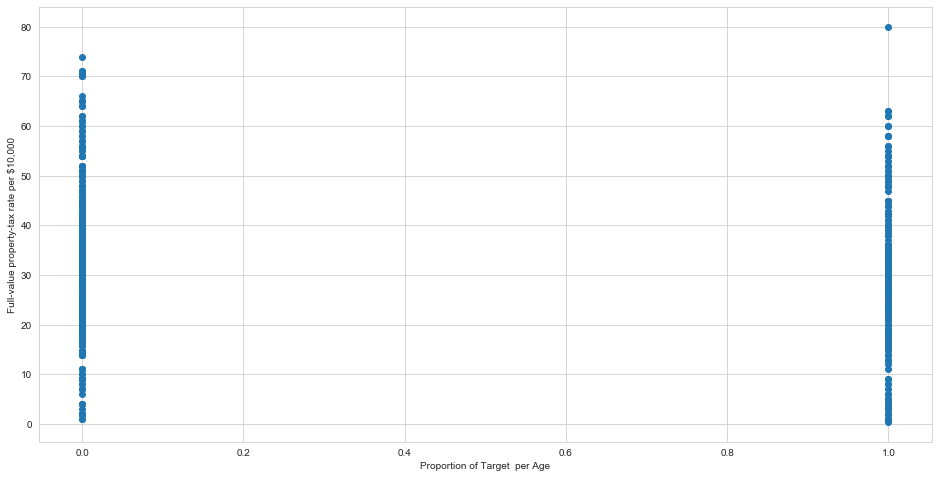

In [45]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(train['Survived'], train['Age'])
ax.set_xlabel('Proportion of Target  per Age')
ax.set_ylabel('Full-value property-tax rate per $10,000')
plt.show()

# Class Distribution 

In [46]:
train.groupby('Survived').size()

Survived
0    549
1    342
dtype: int64

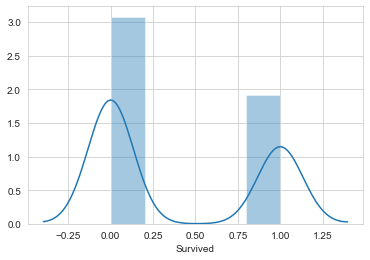

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(train["Survived"]);

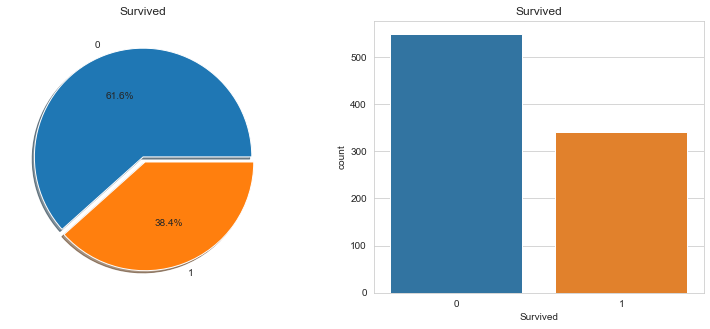

In [48]:
f,ax=plt.subplots(1,2,figsize=(13,5))
train['Survived'].value_counts().plot.pie(explode=[0,0.05],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=train,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


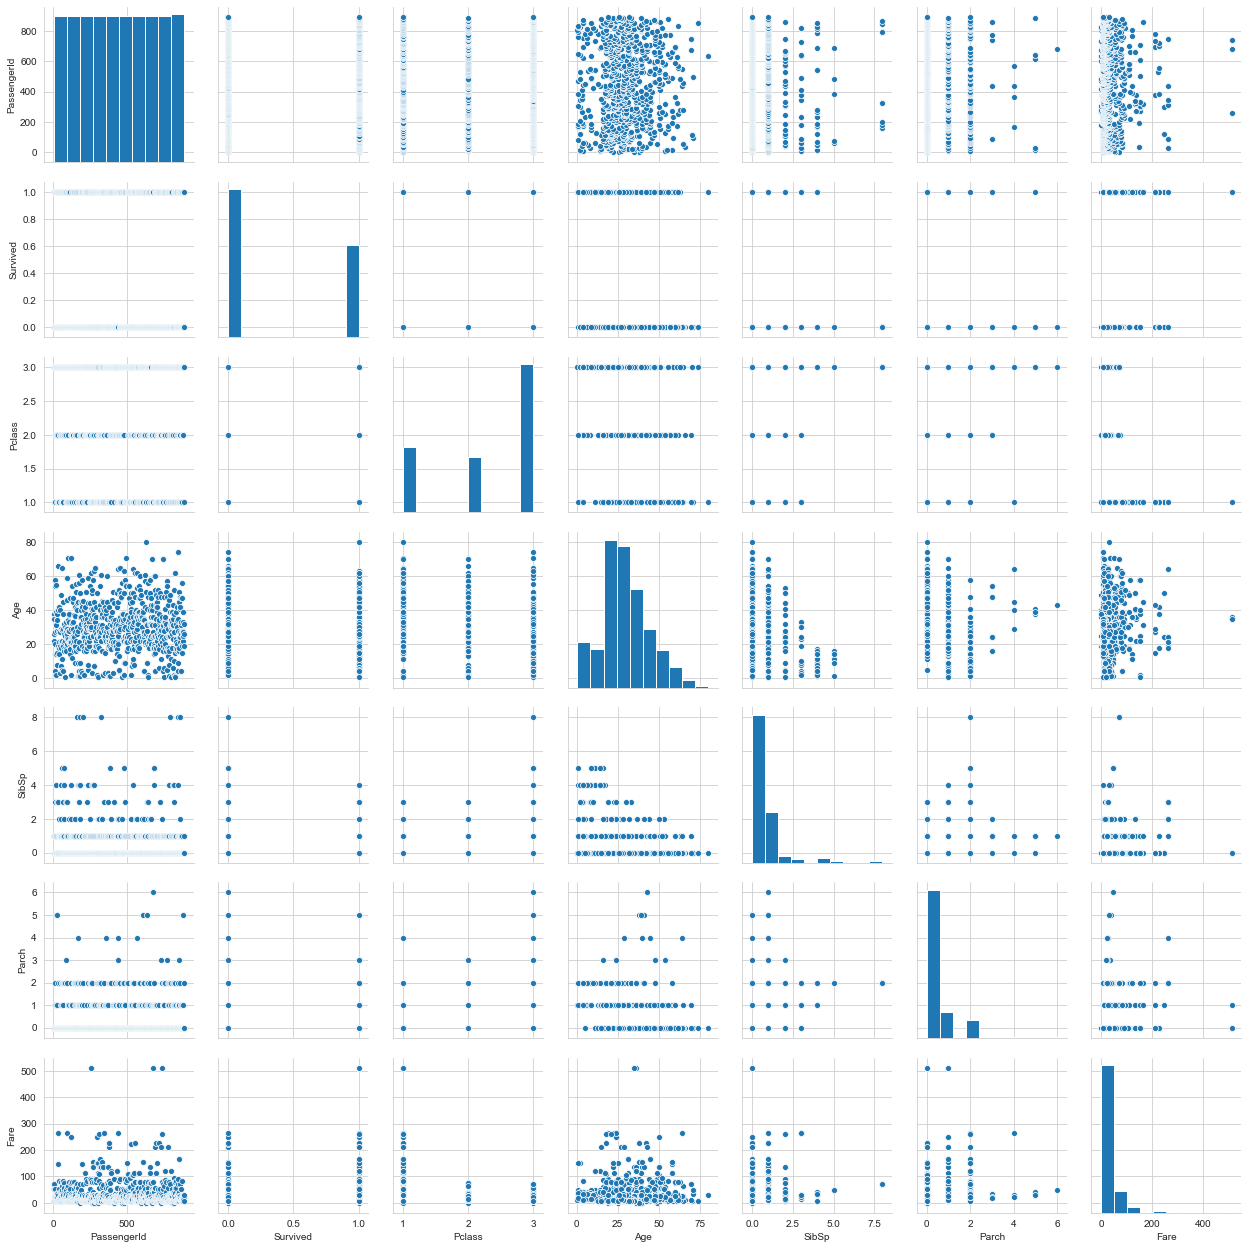

In [49]:
sns.pairplot(train);

/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
/Users/garbamoussa/anaconda

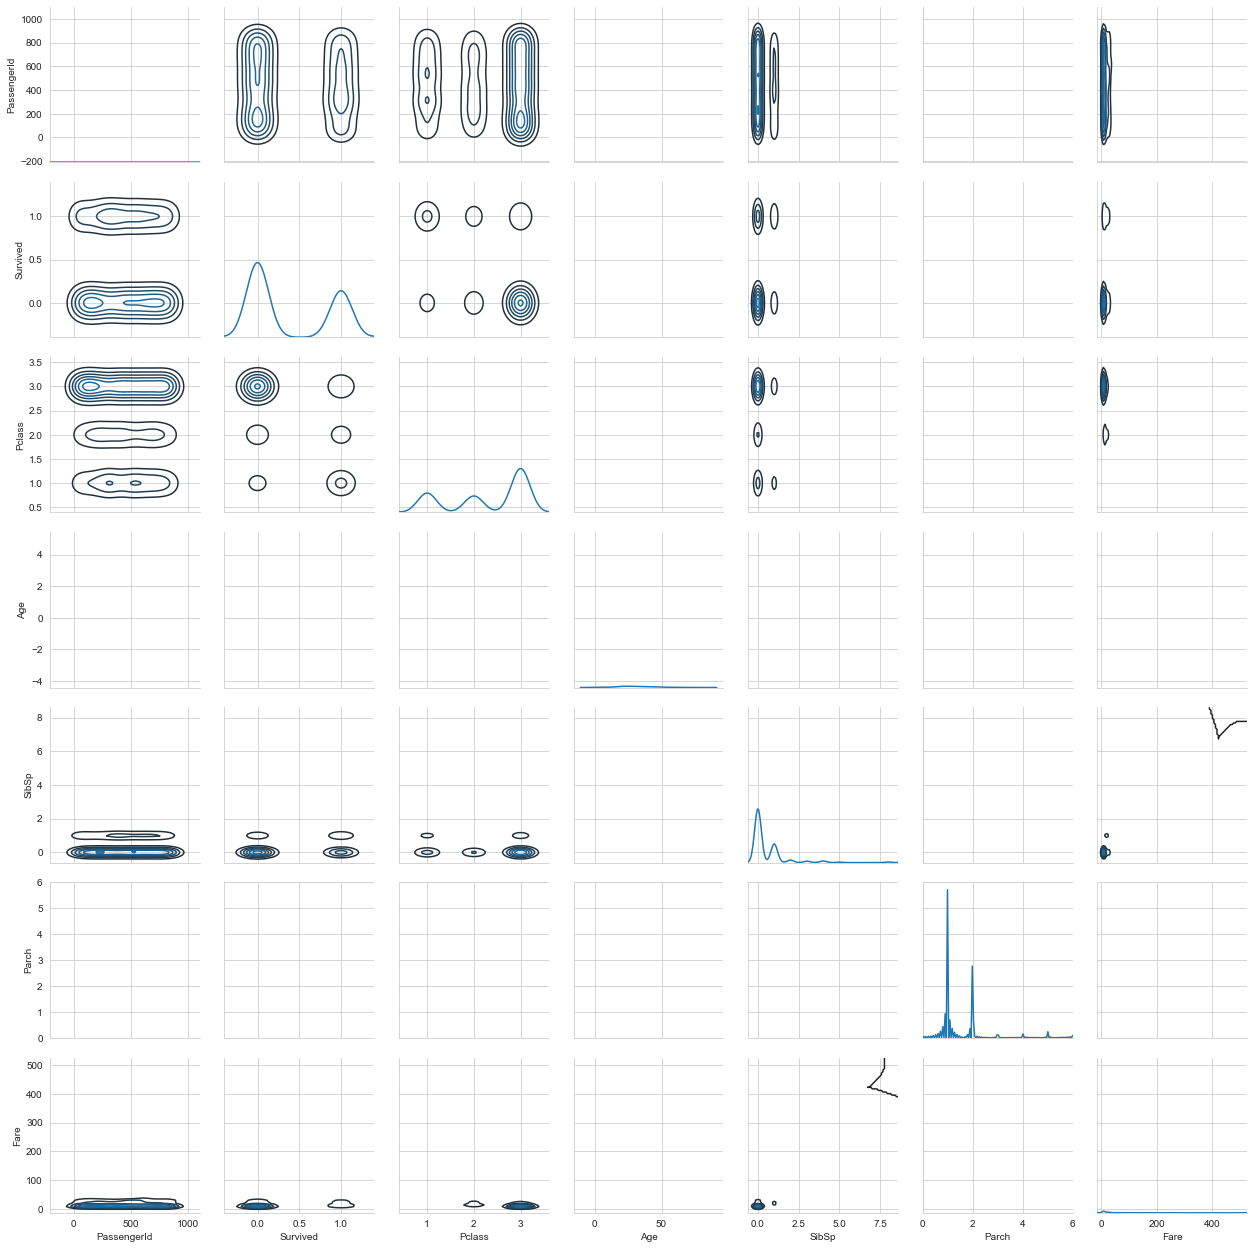

In [50]:
g = sns.PairGrid(train)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [51]:
summary = train.describe()
from pylab import *
ATPNormalized = train
ncols = len(ATPNormalized.columns)
for i in range(ncols):
    mean = summary.iloc[1, i]
    sd = summary.iloc[2, i]
ATPNormalized.iloc[:,i:(i + 1)] = \
        (ATPNormalized.iloc[:,i:(i + 1)] - mean) / sd
array = ATPNormalized.values
boxplot(array)
plt.xlabel("Attribute Index")
plt.ylabel(("Quartile Ranges - Normalized "))
show()

IndexError: single positional indexer is out-of-bounds

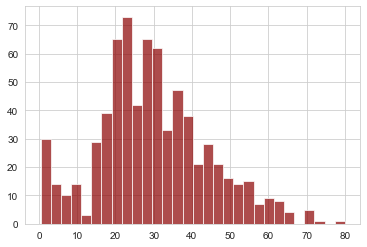

In [52]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

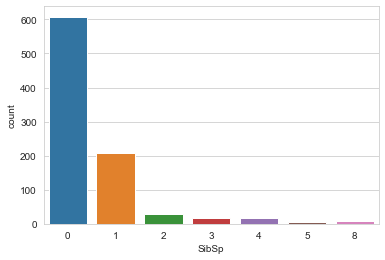

In [53]:
sns.countplot(x='SibSp',data=train)

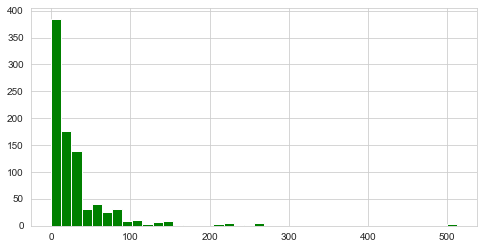

In [54]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
# Data Wrangling : Clean, Transform ..... 
## Handling Missing Data 
Thre are some handling methods : dropna, fillna, isnull and notnull
### Filtering Out Missing Data
### Filling in Missing Data
We want to fill in missing age data instead of just dropping the missing age data rows. 
One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


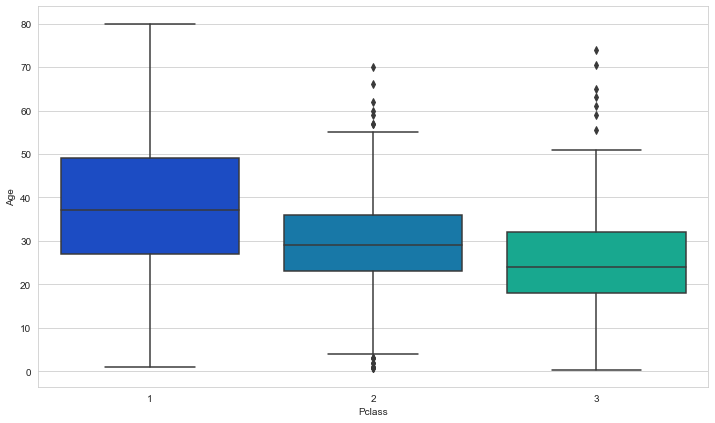

In [55]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [56]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [57]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

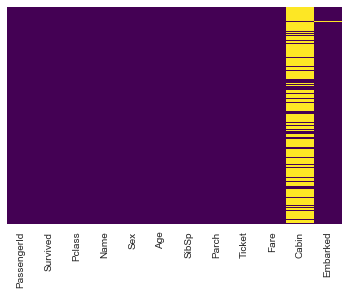

In [58]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [59]:
train.drop('Cabin',axis=1,inplace=True)

In [60]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [61]:
train.dropna(inplace=True)

## Converting Categorical Features 
  We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [63]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [64]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [65]:
train = pd.concat([train,sex,embark],axis=1)

In [66]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


### Great! Our data is ready for our model!

## Building a Logistic Regression model
 Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

In [68]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.20, 
                                                    random_state=101)

## Training and Predicting

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
# none-Adjusted class weights
Model_GBClassifier = GradientBoostingClassifier()
Model_RFclassifier = RandomForestClassifier(n_jobs=-1)
Model_ETClassifier = ExtraTreesClassifier(n_jobs=-1)
Model_BClassfier   = BaggingClassifier(n_jobs=-1)

In [71]:
%%time
print('========================================')
GB_cross_val = (cross_validate(Model_GBClassifier,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_GBClassifier - train_score: %s' %GB_cross_val['train_score'].mean())
print('Model_GBClassifier - train_score: %s' %GB_cross_val['test_score'].mean())
print('========================================')
RF_cross_val = (cross_validate(Model_RFclassifier,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_RFclassifier - train_score: %s' %RF_cross_val['train_score'].mean())
print('Model_RFclassifier - test_score: %s' %RF_cross_val['test_score'].mean())
print('========================================')
ET_cross_val = (cross_validate(Model_ETClassifier,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_ETClassifier - train_score: %s' %ET_cross_val['train_score'].mean())
print('Model_ETClassifier - test_score: %s' %ET_cross_val['test_score'].mean())
print('========================================')
B_cross_val = (cross_validate(Model_BClassfier  ,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=3))
#print('Model_BClassfier - train_score: %s' %B_cross_val['train_score'].mean())
print('Model_BClassfier - ttest_score: %s' %B_cross_val['test_score'].mean())
print('========================================')

Model_GBClassifier - train_score: 0.8419686048528533
Model_RFclassifier - test_score: 0.8359817389855021
Model_ETClassifier - test_score: 0.8256463341991751
Model_BClassfier - ttest_score: 0.838955544820981
CPU times: user 117 ms, sys: 86.5 ms, total: 203 ms
Wall time: 6.45 s


In [72]:
# Adjusted class weights class_weight= {1:10}
Model_GB_Adjusted = GradientBoostingClassifier()
Model_RF_Adjusted = RandomForestClassifier(n_jobs=-1, class_weight= {0:1,1:10})
Model_ET_Adjusted = ExtraTreesClassifier(n_jobs=-1, class_weight= {0:1,1:10})
Model_B_Adjusted   = BaggingClassifier(n_jobs=-1, base_estimator=DecisionTreeClassifier(class_weight= {0:1,1:10}), n_estimators=100 )

In [73]:
%%time
print('========================================')
GB_cross_val = (cross_validate(Model_GBClassifier,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_GBClassifier - train_score: %s' %GB_cross_val['train_score'].mean())
print('Model_GBClassifier - test_score: %s' %GB_cross_val['test_score'].mean())
print('========================================')

RF_cross_val = (cross_validate(Model_RF_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_RFclassifier - train_score: %s' %RF_cross_val['train_score'].mean())
print('Model_RFclassifier - test_score: %s' %RF_cross_val['test_score'].mean())
print('========================================')
ET_cross_val = (cross_validate(Model_ET_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_ETClassifier - train_score: %s' %ET_cross_val['train_score'].mean())
print('Model_ETClassifier - test_score: %s' %ET_cross_val['test_score'].mean())
print('========================================')
B_cross_val = (cross_validate(Model_B_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=3))
#print('Model_BClassfier - train_score: %s' %B_cross_val['train_score'].mean())
print('Model_BClassfier - test_score: %s' %B_cross_val['test_score'].mean())
print('========================================')

Model_GBClassifier - test_score: 0.8423445553692532
Model_RFclassifier - test_score: 0.8296407560161004
Model_ETClassifier - test_score: 0.8270638286975472
Model_BClassfier - test_score: 0.838136471142089
CPU times: user 77.3 ms, sys: 8.49 ms, total: 85.8 ms
Wall time: 1.59 s


In [74]:
# Adjusted class weights class_weight= {1:10}
#Model_GB_Adjusted = GradientBoostingClassifier()
Model_RF_Adjusted = RandomForestClassifier(n_jobs=-1, class_weight= {0:1,1:15}, n_estimators=100)
Model_ET_Adjusted = ExtraTreesClassifier(n_jobs=-1, class_weight= {0:1,1:15}, n_estimators=100)
Model_B_Adjusted  = BaggingClassifier(n_jobs=-1, base_estimator=DecisionTreeClassifier(class_weight= {0:1,1:10}), n_estimators=100 )

In [75]:
%%time
print('========================================')
GB_cross_val = (cross_validate(Model_GBClassifier,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_GBClassifier - train_score: %s' %GB_cross_val['train_score'].mean())
print('Model_GBClassifier - test_score: %s' %GB_cross_val['test_score'].mean())
print('========================================')

RF_cross_val = (cross_validate(Model_RF_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_RFclassifier - train_score: %s' %RF_cross_val['train_score'].mean())
print('Model_RFclassifier - test_score: %s' %RF_cross_val['test_score'].mean())
print('========================================')
ET_cross_val = (cross_validate(Model_ET_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_ETClassifier - train_score: %s' %ET_cross_val['train_score'].mean())
print('Model_ETClassifier - test_score: %s' %ET_cross_val['test_score'].mean())
print('========================================')
B_cross_val = (cross_validate(Model_B_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=3))
#print('Model_BClassfier - train_score: %s' %B_cross_val['train_score'].mean())
print('Model_BClassfier - test_score: %s' %B_cross_val['test_score'].mean())
print('========================================')

Model_GBClassifier - test_score: 0.842215740901346
Model_RFclassifier - test_score: 0.8499305783079898
Model_ETClassifier - test_score: 0.8426758754244444
Model_BClassfier - test_score: 0.8401212991635676
CPU times: user 79 ms, sys: 7.64 ms, total: 86.6 ms
Wall time: 2.04 s


In [76]:
%%time
from sklearn.utils.class_weight import compute_sample_weight
Sample_weight_train = compute_sample_weight(class_weight= {0:1,1:15}, y=y_train)
Model_GB_Adjusted.fit(X_train,y_train,sample_weight=Sample_weight_train)
print('Model_GBClassifier - test score: %s' %roc_auc_score(Model_GB_Adjusted.predict(X_test),y_test))

Model_GBClassifier - test score: 0.6696001235139726
CPU times: user 87.6 ms, sys: 14.4 ms, total: 102 ms
Wall time: 133 ms


In [77]:
# Adjusted class weights
#Model_GB_Adjusted = GradientBoostingClassifier(class_weight= {1:10})
Model_RF_Adjusted = RandomForestClassifier(n_jobs=-1, class_weight= 'balanced', n_estimators=100)
Model_ET_Adjusted = ExtraTreesClassifier(n_jobs=-1, class_weight= 'balanced', n_estimators=100)
Model_B_Adjusted   = BaggingClassifier(n_jobs=-1, base_estimator=DecisionTreeClassifier(class_weight= 'balanced'), n_estimators=100 )

In [78]:
%%time
print('========================================')
RF_cross_val = (cross_validate(Model_RF_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_RFclassifier - train_score: %s' %RF_cross_val['train_score'].mean())
print('Model_RFclassifier - test_score: %s' %RF_cross_val['test_score'].mean())
print('========================================')
ET_cross_val = (cross_validate(Model_ET_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=5))
#print('Model_ETClassifier - train_score: %s' %ET_cross_val['train_score'].mean())
print('Model_ETClassifier - test_score: %s' %ET_cross_val['test_score'].mean())
print('========================================')
B_cross_val = (cross_validate(Model_B_Adjusted,X_train, y=y_train, scoring='roc_auc', n_jobs=-1, cv=3))
#print('Model_BClassfier - train_score: %s' %B_cross_val['train_score'].mean())
print('Model_BClassfier - test_score: %s' %B_cross_val['test_score'].mean())
print('========================================')

Model_RFclassifier - test_score: 0.8539904736003952
Model_ETClassifier - test_score: 0.8423945661119712
Model_BClassfier - test_score: 0.8575156684239081
CPU times: user 59.4 ms, sys: 6.25 ms, total: 65.6 ms
Wall time: 1.77 s


In [172]:
from sklearn.utils.class_weight import compute_sample_weight

#compute_sample_weight(class_weight='balanced', y=y_train)

In [80]:
Model_GB_Adjusted.fit(X_train,y_train,sample_weight=Sample_weight_train)
print('Model_GBClassifier - test score: %s' %roc_auc_score(Model_GB_Adjusted.predict(X_test),y_test))

Model_GBClassifier - test score: 0.6765283018867925


In [81]:
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

def plot_learning_curve(estimator1, X, y, estimator2, ylim=(0, 1.1), cv=2, n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    
    
    plt.figure(figsize=(12,6))
    #plt.title("Learning curves for %s" % type(estimator1).__name__)
    #plt.title("Learning curves for %s" %(estimator1))
    plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.xscale('log')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.subplot(1, 2, 1)
    plt.title("Learning curves for %s" % type(estimator1).__name__)
    plt.plot(
        train_sizes, train_scores_mean, 'o-',
        color="r", #linewidth=3, 
        label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, 'o-',
        color="olive", 
        label="Cross-validation score")
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1,
        color="firebrick")
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color="darkgoldenrod")
    plt.legend(loc="best")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.subplot(1, 2, 2)
    plt.title("Learning curves for %s with 70 percent of best features" % type(estimator1).__name__)
    plt.plot(
        train_sizes, train_scores_mean, 'o-',
        color="r", #linewidth=3, 
        label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, 'o-',
        color="olive", 
        label="Cross-validation score")
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1,
        color="firebrick")
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color="darkgoldenrod")
    plt.legend(loc="best")
    plt.savefig("Learning curves for %s" % type(estimator1).__name__)

In [82]:
df_models = pd.DataFrame({'Models':[], 'Sample':[], 'Accuracy':[],'Accuracy with 70% best features':[]})
data=[]
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import mutual_info_classif

def modelize(list_clf,X,y,X_test,y_test):
    selector = SelectPercentile(mutual_info_classif,percentile=70)
    #selector = SelectPercentile(percentile=70)
    for clf in list_clf:
        Clf1 = clf().fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf())]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=2 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted'),accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Training', 'Accuracy':accuracy_score(y,Clf1.predict(X)),'Accuracy with 70% best features':accuracy_score(y,Clf2.predict(X)) })
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Test', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test)),'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')

In [83]:
from sklearn.linear_model import LogisticRegressionCV , PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import NuSVC, LinearSVC, SVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

In [84]:
generalized_linear_model = [LogisticRegressionCV,PassiveAggressiveClassifier]
support_vector_machines =  [NuSVC, LinearSVC]   
decisionTreeClassification=[DecisionTreeClassifier]
ensemble_methods = [RandomForestClassifier , ExtraTreesClassifier,AdaBoostClassifier, GradientBoostingClassifier]
naive_bayes_model = [GaussianNB, MultinomialNB, ComplementNB]

/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logisti

Model : LogisticRegressionCV
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.811533                   0.809624           /    0.794655                   0.792171
Test     :       0.814607                   0.809730           /    0.803371                   0.798199
Model : PassiveAggressiveClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.625879                   0.599262           /    0.661041                   0.575201
Test     :       0.646067                   0.626765           /    0.646067                   0.545191


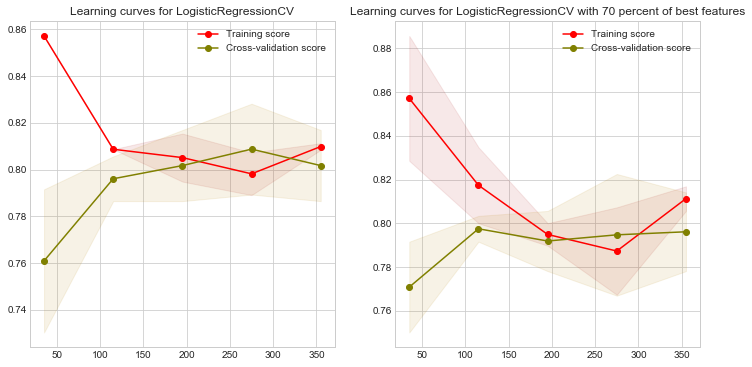

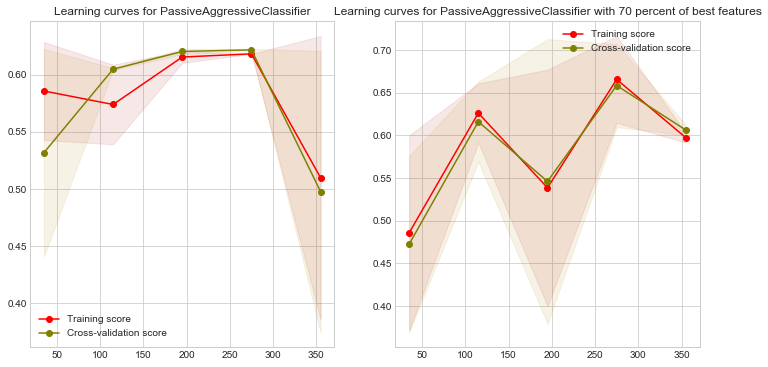

In [85]:
#Generalized Linear Model
modelize(generalized_linear_model,X_train,y_train, X_test, y_test)

In [86]:
def modelize_svc(list_clf,X,y,X_test,y_test):
    selector = SelectPercentile(mutual_info_classif,percentile=70)
    for clf in list_clf:
        Clf1 = clf(kernel='poly').fit(X,y)
        Clf2 = Pipeline([('Feature Selection',selector),('Classification',clf(kernel='poly'))]).fit(X,y)
        cv = StratifiedShuffleSplit(n_splits=2 , test_size=.3, random_state=51)
        print('Model : %s' %type(Clf1).__name__)
        print('With all features                                              /    With 70% of the best features')
        print('                 Accuracy Score             F1 Score                Accuracy Score             F1 Score')
        print('training :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y,Clf1.predict(X)),f1_score(y,Clf1.predict(X),average='weighted'),accuracy_score(y,Clf2.predict(X)),f1_score(y,Clf2.predict(X),average='weighted')))
        print('Test     :       %f                   %f           /    %f                   %f' 
              %(accuracy_score(y_test,Clf1.predict(X_test)),f1_score(y_test,Clf1.predict(X_test),average='weighted')
                ,accuracy_score(y_test,Clf2.predict(X_test)),f1_score(y_test,Clf2.predict(X_test),average='weighted')))
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Training', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test))
                       ,'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        data.insert(0,{'Models':type(Clf1).__name__, 'Sample':'Test', 'Accuracy':accuracy_score(y_test,Clf1.predict(X_test))
                       ,'Accuracy with 70% best features':accuracy_score(y_test,Clf2.predict(X_test)) })
        plot_learning_curve(Clf1, X, y, Clf2, cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
        print('=============================================')



/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Model : NuSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.998594                   0.998593           /    0.995781                   0.995776
Test     :       0.573034                   0.447015           /    0.561798                   0.484217
Model : LinearSVC
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.677918                   0.619073           /    0.687764                   0.636739
Test     :       0.657303                   0.589277           /    0.657303                   0.584014


/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


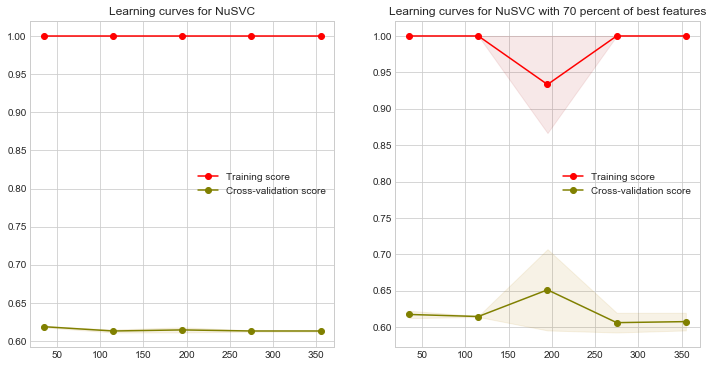

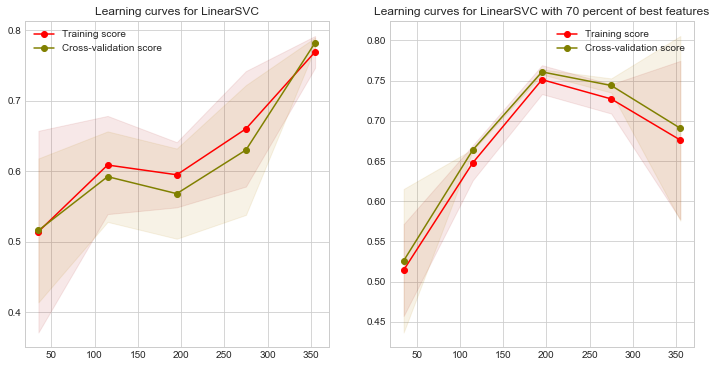

In [87]:
#Support Vector Machine
modelize(support_vector_machines,X_train,y_train, X_test, y_test)

Model : DecisionTreeClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       1.000000                   1.000000           /    0.981716                   0.981652
Test     :       0.780899                   0.781151           /    0.769663                   0.769928


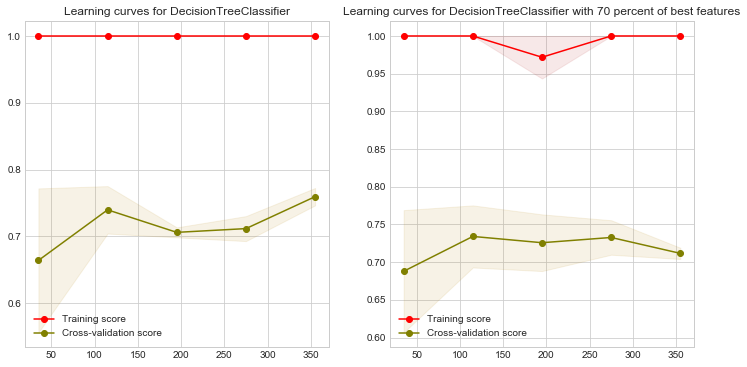

In [88]:
#Decision Tree
modelize(decisionTreeClassification,X_train,y_train, X_test, y_test)

/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model : RandomForestClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.973277                   0.973140           /    0.922644                   0.921823
Test     :       0.808989                   0.805244           /    0.758427                   0.756776
Model : ExtraTreesClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       1.000000                   1.000000           /    1.000000                   1.000000
Test     :       0.825843                   0.822054           /    0.780899                   0.775136


/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model : AdaBoostClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.836850                   0.835352           /    0.838256                   0.836997
Test     :       0.792135                   0.790038           /    0.803371                   0.801387
Model : GradientBoostingClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.908579                   0.907140           /    0.894515                   0.892380
Test     :       0.859551                   0.857087           /    0.808989                   0.805244


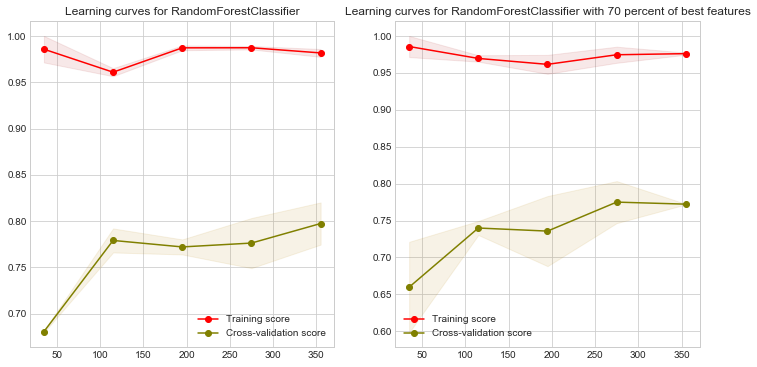

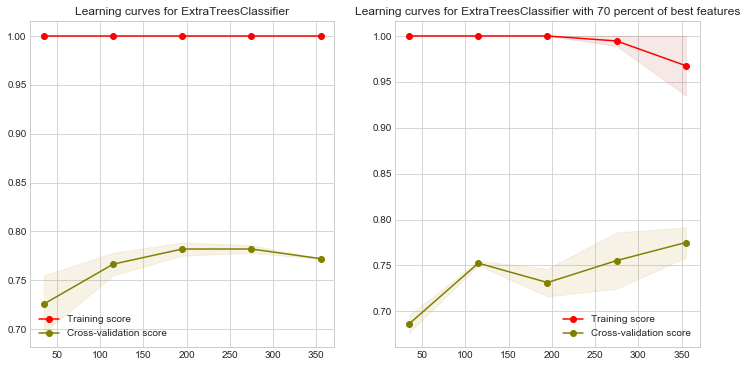

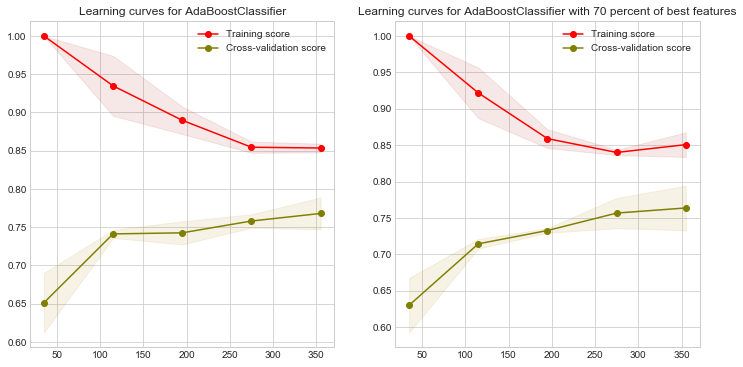

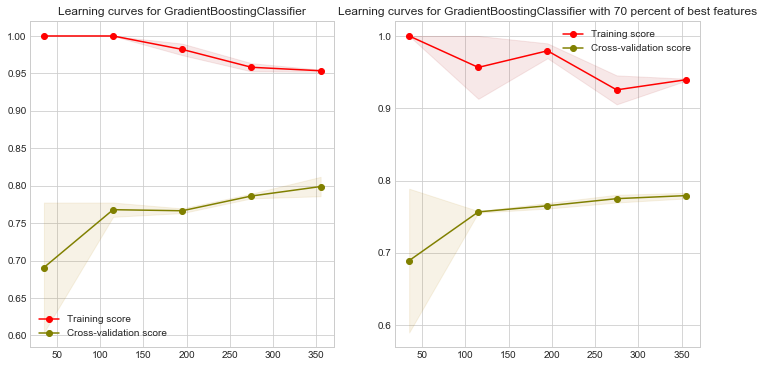

In [89]:
#Ensemble Methods
modelize(ensemble_methods,X_train,y_train, X_test, y_test)       

Model : MultinomialNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.659634                   0.649089           /    0.690577                   0.665996
Test     :       0.691011                   0.685591           /    0.702247                   0.687921
Model : ComplementNB
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.658228                   0.648329           /    0.682138                   0.666524
Test     :       0.685393                   0.680499           /    0.713483                   0.711525


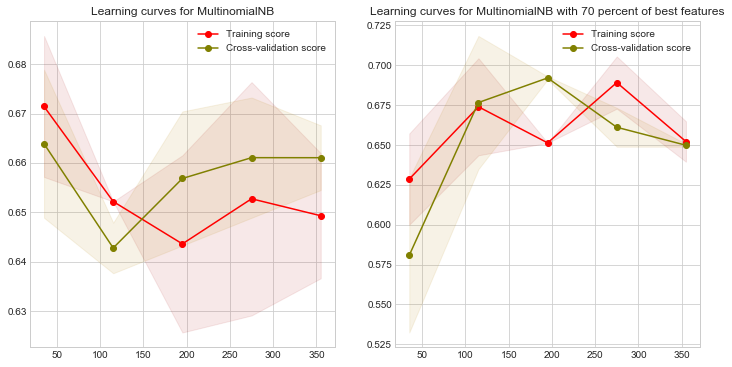

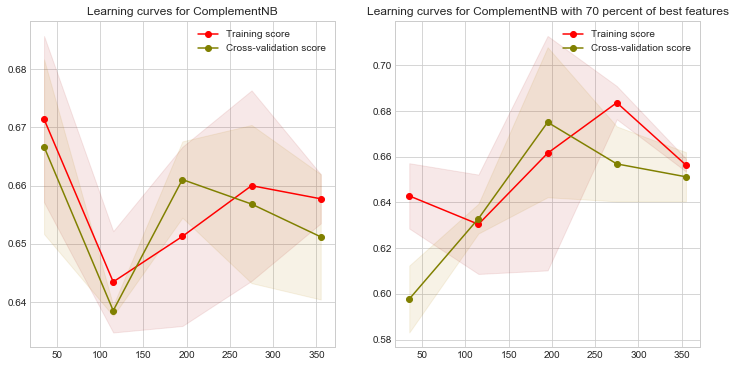

In [90]:
#Naives bayes
modelize([ MultinomialNB, ComplementNB],X_train,y_train, X_test, y_test)

Model : MLPClassifier
With all features                                              /    With 70% of the best features
                 Accuracy Score             F1 Score                Accuracy Score             F1 Score
training :       0.786217                   0.782258           /    0.774965                   0.771780
Test     :       0.786517                   0.782331           /    0.752809                   0.748963


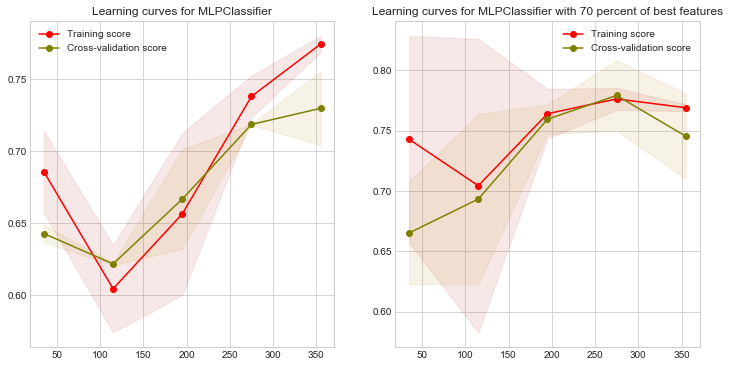

In [91]:
#Neural Network - Consomme beaucoup trop d'energie
Neural_network= [MLPClassifier]
modelize(Neural_network,X_train,y_train, X_test, y_test)

In [92]:
models_df =pd.concat([pd.DataFrame(data),df_models],ignore_index=True)  
models_df.sort_values(by=['Accuracy','Models','Sample'], ascending=False, axis=0, inplace=True)
test_df = pd.DataFrame(np.array(models_df[['Accuracy', 'Accuracy with 70% best features']]),
                       index=[models_df['Models'],models_df['Sample']], columns=['Accuracy', 'Accuracy with 70% best features'])

/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [93]:
test_df

Accuracy  \
Models                      Sample               
ExtraTreesClassifier        Training  1.000000   
DecisionTreeClassifier      Training  1.000000   
NuSVC                       Training  0.998594   
RandomForestClassifier      Training  0.973277   
GradientBoostingClassifier  Training  0.908579   
                            Test      0.859551   
AdaBoostClassifier          Training  0.836850   
ExtraTreesClassifier        Test      0.825843   
LogisticRegressionCV        Test      0.814607   
                            Training  0.811533   
RandomForestClassifier      Test      0.808989   
AdaBoostClassifier          Test      0.792135   
MLPClassifier               Test      0.786517   
                            Training  0.786217   
DecisionTreeClassifier      Test      0.780899   
MultinomialNB               Test      0.691011   
ComplementNB                Test      0.685393   
LinearSVC                   Training  0.677918   
MultinomialNB               Training  0.659634   
ComplementNB                Training  0.658228   
LinearSVC                   Test      0.657303   
PassiveAggressiveClassifier Test      0.646067   
                            Training  0.625879   
NuSVC                       Test      0.573034   

                                      Accuracy with 70% best features  
Models                      Sample                                     
ExtraTreesClassifier        Training                         1.000000  
DecisionTreeClassifier      Training                         0.981716  
NuSVC                       Training                         0.995781  
RandomForestClassifier      Training                         0.922644  
GradientBoostingClassifier  Training                         0.894515  
                            Test                             0.808989  
AdaBoostClassifier          Training                         0.838256  
ExtraTreesClassifier        Test                             0.780899  
LogisticRegressionCV        Test                             0.803371  
                            Training                         0.794655  
RandomForestClassifier      Test                             0.758427  
AdaBoostClassifier          Test                             0.803371  
MLPClassifier               Test                             0.752809  
                            Training                         0.774965  
DecisionTreeClassifier      Test                             0.769663  
MultinomialNB               Test                             0.702247  
ComplementNB                Test                             0.713483  
LinearSVC                   Training                         0.687764  
MultinomialNB               Training                         0.690577  
ComplementNB                Training                         0.682138  
LinearSVC                   Test                             0.657303  
PassiveAggressiveClassifier Test                             0.646067  
                            Training                         0.661041  
NuSVC                       Test                             0.561798

In [94]:
test_df1=pd.merge(models_df[models_df['Sample']=='Test'],models_df[models_df['Sample']=='Training'],how='inner',on='Models')
final_model = pd.DataFrame( np.array(test_df1[['Sample_y','Accuracy_y', 'Accuracy with 70% best features_y','Sample_x','Accuracy_x', 'Accuracy with 70% best features_x']]),
            index=test_df1['Models'], columns=['','Accuracy', 'Accuracy with 70% best features','','Accuracy', 'Accuracy with 70% best features'])

#final_model= pd.read_csv('models_stemmisation.csv')
final_model.sort_values(by=['Accuracy.1'], ascending=False, axis=0, inplace=True)
final_model.rename(index=str,columns={'Unnamed: 1':'','Unnamed: 4':'', 'Accuracy.1':'Accuracy', 'Accuracy with 70% best features.1':'Accuracy with 70% best features'},inplace=True)

KeyError: 'Accuracy.1'

In [95]:
final_model

,,Accuracy,Accuracy with 70% best features,,Accuracy,Accuracy with 70% best features
Models,,,,,,
GradientBoostingClassifier,Training,0.908579,0.894515,Test,0.859551,0.808989
ExtraTreesClassifier,Training,1,1,Test,0.825843,0.780899
LogisticRegressionCV,Training,0.811533,0.794655,Test,0.814607,0.803371
RandomForestClassifier,Training,0.973277,0.922644,Test,0.808989,0.758427
AdaBoostClassifier,Training,0.83685,0.838256,Test,0.792135,0.803371
MLPClassifier,Training,0.786217,0.774965,Test,0.786517,0.752809
DecisionTreeClassifier,Training,1,0.981716,Test,0.780899,0.769663
MultinomialNB,Training,0.659634,0.690577,Test,0.691011,0.702247
ComplementNB,Training,0.658228,0.682138,Test,0.685393,0.713483


# Create models 

In [97]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold

random_state = 42
kf = KFold(n_splits=2,random_state=random_state)
n_iter= 50
Model_final_GradientBoostingClassifier = GradientBoostingClassifier(learning_rate=0.02,n_estimators=18,random_state=0).fit(X_train,y_train)
Model_final_ExtraTreesClassifier = ExtraTreesClassifier(max_depth= 443.0, max_features= 'sqrt', min_samples_split= 5, n_estimators=117).fit(X_train,y_train)

Model_final_LogReg  = LogisticRegression(C=38.7710843373494).fit(X_train,y_train)
Model_final_RandomForestClassifier = RandomForestClassifier(max_depth=7,min_samples_split=4,n_estimators=19,random_state=3).fit(X_train,y_train)


/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [100]:
#MATRICES DE CONFUSIONS
from sklearn.metrics import confusion_matrix
cm_ETree = confusion_matrix(y_test, Model_final_ExtraTreesClassifier.predict(X_test))
cm_RM = confusion_matrix(y_test, Model_final_RandomForestClassifier.predict(X_test))
cm_LogReg = confusion_matrix(y_test, Model_final_LogReg.predict(X_test))
cm_GB = confusion_matrix(y_test, Model_final_GradientBoostingClassifier.predict(X_test))

In [101]:
#MATRICES DE CONFUSIONS NORMALISEES
cm_ETree = cm_ETree.astype('float') / cm_ETree.sum(axis=1)[:, np.newaxis]
cm_RM = cm_RM.astype('float') / cm_RM.sum(axis=1)[:, np.newaxis]
cm_LogReg = cm_LogReg.astype('float') / cm_LogReg.sum(axis=1)[:, np.newaxis]
cm_GB = cm_GB.astype('float') / cm_GB.sum(axis=1)[:, np.newaxis]

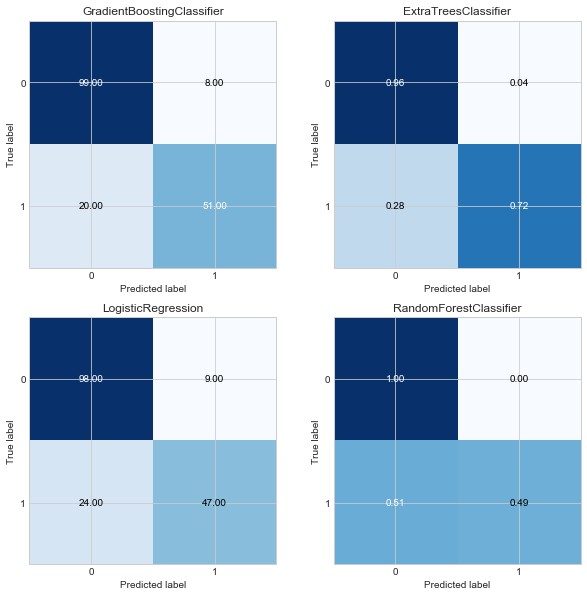

In [106]:
from sklearn.utils.multiclass import unique_labels
classes = unique_labels(y_test)


fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))
aX = [ax1, ax2,ax3,ax4]
dict_models = ['GradientBoostingClassifier',  'ExtraTreesClassifier',  'LogisticRegression',  'RandomForestClassifier']
for IDX, i in enumerate([cm_ETree, cm_RM, cm_LogReg, cm_GB]):
    im = aX[IDX].imshow(i, interpolation='nearest', cmap=plt.cm.Blues)
    

    # visualisation des données 
    aX[IDX].set(xticks=np.arange(i.shape[1]), yticks=np.arange(i.shape[0]),
           xticklabels=classes, yticklabels=classes, 
           title= dict_models[IDX],
           ylabel='True label',
           xlabel='Predicted label')
    
    fmt = '.2f' if normalize else 'd'
    thresh = i.max() / 2.
    for t in range(i.shape[0]):
        for j in range(i.shape[1]):
            aX[IDX].text(j, t, format(i[t, j], fmt),
                    ha="center", va="center",
                    color="white" if i[t, j] > thresh else "black")
    

# GradientBoostingClassifier

In [123]:
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    }

In [124]:
Model_final_GradientBoostingClassifier = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, min_samples_leaf=0.1, min_samples_split = 0.1).fit(X_train,y_train)


In [125]:
GB_pred = Model_final_GradientBoostingClassifier.predict(X_test)

In [126]:
GB_pred

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0])

In [127]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, GB_pred))

print("Classification Report")
print(classification_report(y_test, GB_pred))

Confusion Matrix:
[[100   7]
 [ 24  47]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       107
           1       0.87      0.66      0.75        71

    accuracy                           0.83       178
   macro avg       0.84      0.80      0.81       178
weighted avg       0.83      0.83      0.82       178



In [134]:
matrix_GB = confusion_matrix(y_test, GB_pred)

In [135]:
matrix_GB

array([[100,   7],
       [ 24,  47]])

TP = number of instances labeled as 'yes' and classified as 'yes' correctly
TN = number of instances labeled as 'no' and classified as 'no' correctly
FP = number of instances labeled as 'no' but classified as 'yes'
FN = number of instances labeled as 'yes' but classified as 'no'

In [133]:
type(matrix_GB)

pandas.core.frame.DataFrame

In [141]:
print('====================== Les métriques de performances =======================')
total =sum(sum(matrix_GB))
accuracy =(matrix_GB[0,0]+matrix_GB[1,1])/total
Precision = matrix_GB[0,0]/ (matrix_GB[0,0] + matrix_GB[0,1]) 
Sensibility = matrix_GB[0,0]/ (matrix_GB[0,0] + matrix_GB[1,0]) 
specificity = matrix_GB[1,1]/(matrix_GB[1,0]+matrix_GB[1,1])

print ('Accuracy : ', accuracy)
print ('Precision : ', Precision)
print ('Sensibility : ', Sensibility)
print ('specificity : ', specificity)

====================== Les métriques de performances =======================
Accuracy :  0.8258426966292135
Precision :  0.9345794392523364
Sensibility :  0.8064516129032258
specificity :  0.6619718309859155


In [138]:
Sensibility

0.8064516129032258

In [139]:
Precision

0.9345794392523364

# ExtraTreesClassifier Classifiction

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [142]:
Model_final_ExtraTreesClassifier = ExtraTreesClassifier(max_depth= 443.0, max_features= 'sqrt', min_samples_split= 5, n_estimators=117)

Model_final_ExtraTreesClassifier.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=443.0, max_features='sqrt', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=117,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [143]:
Ext_pred = Model_final_ExtraTreesClassifier.predict(X_test)

In [144]:
Ext_pred

array([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0])

In [145]:
print(confusion_matrix(y_test,Ext_pred))

[[99  8]
 [23 48]]


In [147]:
matrix_EXT = confusion_matrix(y_test, Ext_pred)

In [146]:
print(classification_report(y_test,Ext_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       107
           1       0.86      0.68      0.76        71

    accuracy                           0.83       178
   macro avg       0.83      0.80      0.81       178
weighted avg       0.83      0.83      0.82       178



In [148]:
print('====================== Les métriques de performances =======================')
total =sum(sum(matrix_EXT))
accuracy =(matrix_EXT[0,0]+matrix_EXT[1,1])/total
Precision = matrix_EXT[0,0]/ (matrix_EXT[0,0] + matrix_EXT[0,1]) 
Sensibility = matrix_EXT[0,0]/ (matrix_EXT[0,0] + matrix_EXT[1,0]) 
specificity = matrix_EXT[1,1]/(matrix_EXT[1,0]+matrix_EXT[1,1])

print ('Accuracy : ', accuracy)
print ('Precision : ', Precision)
print ('Sensibility : ', Sensibility)
print ('specificity : ', specificity)

====================== Les métriques de performances =======================
Accuracy :  0.8258426966292135
Precision :  0.9252336448598131
Sensibility :  0.8114754098360656
specificity :  0.676056338028169


# Random Forest Classification

In [149]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
Model_final_RandomForestClassifier = RandomForestClassifier(max_depth=7,min_samples_split=4,n_estimators=100,random_state=3)
Model_final_RandomForestClassifier.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [157]:
rf_pred = Model_final_RandomForestClassifier.predict(X_test)
matrix_RF = confusion_matrix(y_test, rf_pred)

In [158]:
print(confusion_matrix(y_test,rf_pred))

[[99  8]
 [18 53]]


In [159]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.88       107
           1       0.87      0.75      0.80        71

    accuracy                           0.85       178
   macro avg       0.86      0.84      0.84       178
weighted avg       0.86      0.85      0.85       178



In [160]:
print('====================== Les métriques de performances =======================')
total =sum(sum(matrix_RF))
accuracy =(matrix_RF[0,0]+matrix_RF[1,1])/total
Precision = matrix_RF[0,0]/ (matrix_RF[0,0] + matrix_RF[0,1]) 
Sensibility = matrix_RF[0,0]/ (matrix_RF[0,0] + matrix_RF[1,0]) 
specificity = matrix_RF[1,1]/(matrix_RF[1,0]+matrix_RF[1,1])

print ('Accuracy : ', accuracy)
print ('Precision : ', Precision)
print ('Sensibility : ', Sensibility)
print ('specificity : ', specificity)

====================== Les métriques de performances =======================
Accuracy :  0.8539325842696629
Precision :  0.9252336448598131
Sensibility :  0.8461538461538461
specificity :  0.7464788732394366


## LogisticRegression Classification

In [161]:
Model_final_LogReg  = LogisticRegression(C=38.7710843373494)
Model_final_LogReg.fit(X_train,y_train)

/Users/garbamoussa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=38.7710843373494, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [165]:
LogReg_pred = Model_final_LogReg.predict(X_test)
matrix_logReg = confusion_matrix(y_test, LogReg_pred)

In [163]:
print(confusion_matrix(y_test,LogReg_pred))

[[98  9]
 [24 47]]


In [164]:
print(classification_report(y_test,LogReg_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       107
           1       0.84      0.66      0.74        71

    accuracy                           0.81       178
   macro avg       0.82      0.79      0.80       178
weighted avg       0.82      0.81      0.81       178



In [166]:
print('====================== Les métriques de performances =======================')
total =sum(sum(matrix_RF))
accuracy =(matrix_logReg[0,0]+matrix_logReg[1,1])/total
Precision = matrix_logReg[0,0]/ (matrix_logReg[0,0] + matrix_logReg[0,1]) 
Sensibility = matrix_logReg[0,0]/ (matrix_logReg[0,0] + matrix_logReg[1,0]) 
specificity = matrix_logReg[1,1]/(matrix_logReg[1,0]+matrix_logReg[1,1])

print ('Accuracy : ', accuracy)
print ('Precision : ', Precision)
print ('Sensibility : ', Sensibility)
print ('specificity : ', specificity)

====================== Les métriques de performances =======================
Accuracy :  0.8146067415730337
Precision :  0.9158878504672897
Sensibility :  0.8032786885245902
specificity :  0.6619718309859155


In [43]:
test = pd.read_csv('../input/test.csv')

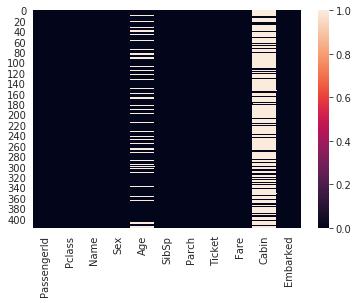

In [44]:
sns.heatmap(test.isnull())

In [45]:
test.drop('Cabin',axis=1,inplace=True)

In [46]:
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 32.7+ KB


In [48]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [49]:
test['Age'] = test[['Age','Pclass']].apply(impute_age,axis=1)

In [50]:
sex_test = pd.get_dummies(test['Sex'],drop_first=True)
embark_test= pd.get_dummies(test['Embarked'],drop_first=True)

In [51]:
test.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [52]:
test = pd.concat([test,sex_test,embark_test],axis=1)

In [53]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,1
2,894,2,62.0,0,0,9.6875,1,1,0
3,895,3,27.0,0,0,8.6625,1,0,1
4,896,3,22.0,1,1,12.2875,0,0,1


In [54]:
test_prediction = rf.predict(test)

In [55]:
test_prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [56]:
test_pred = pd.DataFrame(test_prediction, columns= ['Survived'])

In [57]:
new_test = pd.concat([test, test_pred], axis=1, join='inner')

In [58]:
new_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Survived
0,892,3,34.5,0,0,7.8292,1,1,0,0
1,893,3,47.0,1,0,7.0000,0,0,1,0
2,894,2,62.0,0,0,9.6875,1,1,0,0
3,895,3,27.0,0,0,8.6625,1,0,1,0
4,896,3,22.0,1,1,12.2875,0,0,1,0


In [59]:
df= new_test[['PassengerId' ,'Survived']]

In [60]:
df.to_csv('predictions.csv' , index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## If you like it, please vote.
# Thank you :)